In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ranksums, mannwhitneyu, friedmanchisquare
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.utils.random import sample_without_replacement
from UBIC import fit_blr, UBIC, decreasing_values_indices
# from skscope_tools import best_subset_all_solutions, abess_all_solutions

from tqdm import tqdm

from pysr import PySRRegressor

fontsize = 20 # for plots

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.4.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
Best-subset solvers are NOT installed.
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

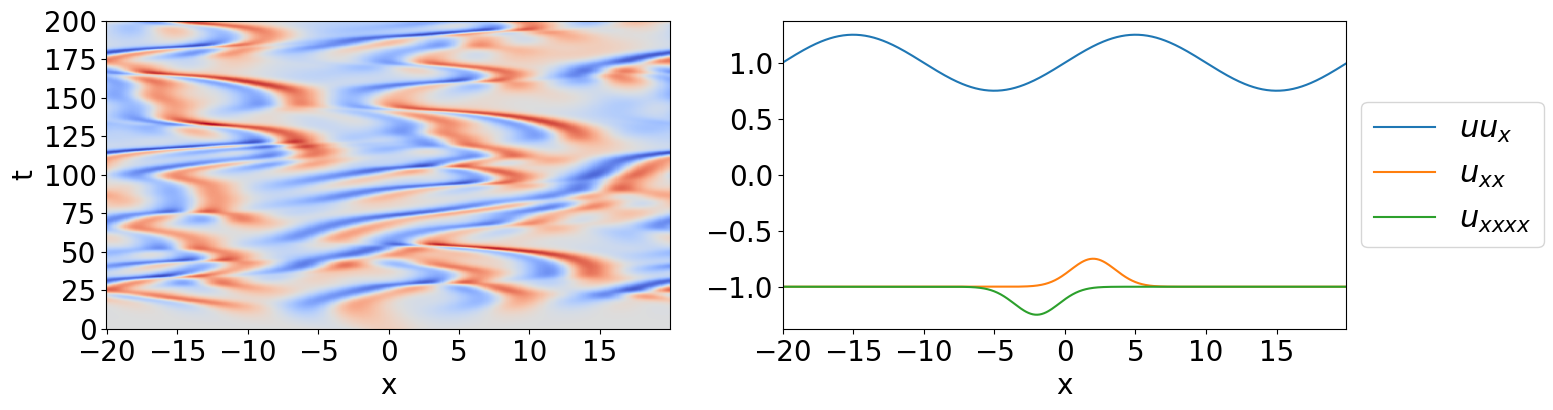

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


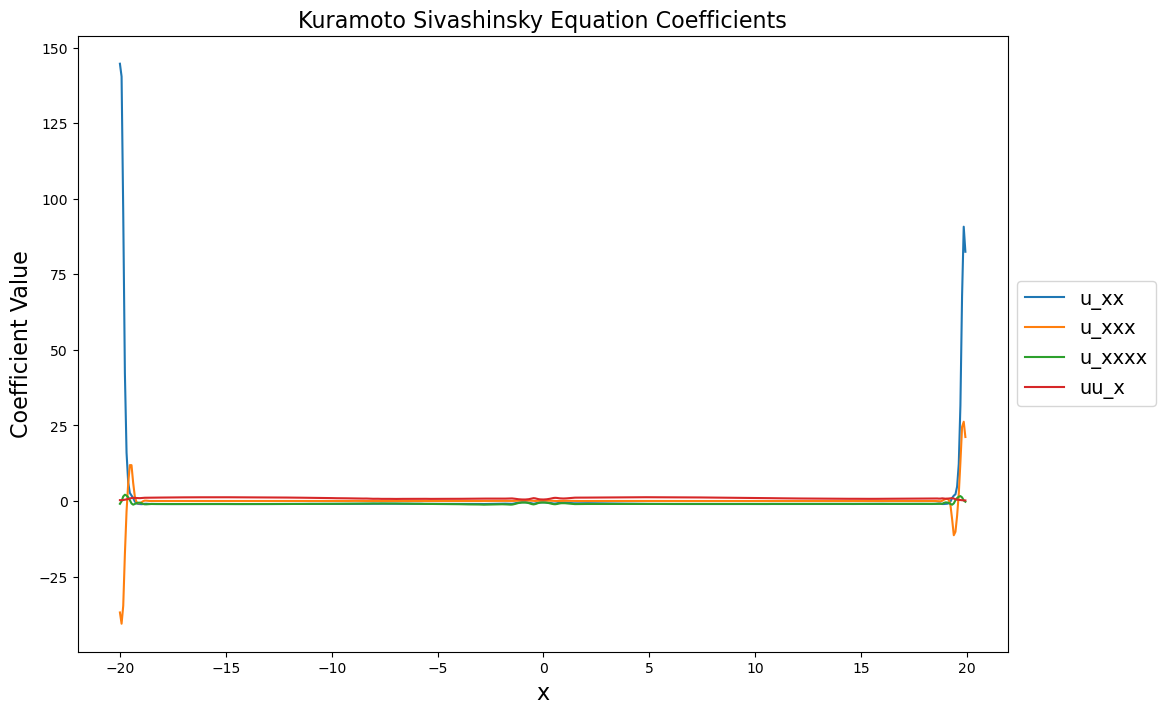

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
candidates = {(0, 1, 3, 4, 6, 7, 8, 9, 11),
              (0, 1, 3, 4, 6, 7, 10, 11),
              (1, 2, 3, 4, 6, 7, 8, 12, 15, 16),
              (3, 4, 6, 7),
              (3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 18),
              (3, 4, 6, 7, 9, 12),
              (3, 4, 6, 7, 9, 12, 18),
              (3, 4, 6, 7, 13),
              (4, 6, 7),
              (6, 7),
              (7,)}
candidates = sorted(candidates, key=len)
rhs_des[4], rhs_des[6], rhs_des[7]

('u_xx', 'u_xxxx', 'uu_x')

In [11]:
f_u_xx, f_u_xxxx, f_uu_x = linear_fit_grouped_data((Theta_grouped, Ut_grouped), 
                                             considered_indices=candidates[2])

In [12]:
model = PySRRegressor(
    niterations=100,  
    binary_operators=["+", "-", "*"],
    unary_operators=[
        "cos",
        "sin", 
        "exp"
    ],
)

In [13]:
model.fit(x.reshape(-1,1), f_uu_x.reshape(-1,1))

Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.870e+05
Head worker occupation: 27.6%
Progress: 403 / 1500 total iterations (26.867%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           6.653e-02  7.971e+00  y = cos(-0.38859)
4           6.184e-02  3.652e-02  y = cos(0.033796 * x₀)
6           5.783e-02  3.358e-02  y = cos((-0.034639 * x₀) + -0.1425)
7           5.179e-02  1.102e-01  y = cos(cos(0.59245 + (0.14961 * x₀)))
8           4.349e-02  1.746e-01  y = cos(sin(cos(0.59245 + (0.14961 * x₀))))
9           2.739e-02  4.623e-01  y = cos(cos(0.62826 + (x₀ * 0.1529))) + 0.14852
10          2.648e-02  3.387e-02  y = cos(cos(sin(x₀ * 0.31716) + 0.52845)) + 0.18543
11          2.644e-02  1.698e-03  y = cos(cos(sin(sin(0.31722 * x₀)) + 0.51152)) + 0.20259
12          2.074e-02  2.428e-01  y = cos(cos(sin(-0.32511 + (x₀ * 0.31309)) + 0.61409)) + 0.175...
                                

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x0   
	1         7.621811                                   cos(-0.38858923)   
	2         0.036534                             cos(-0.033978414 * x0)   
	3         0.034950               cos((0.03330136 * x0) - -0.16811216)   
	4         0.107442           cos(cos(0.59244543 + (0.14961119 * x0)))   
	5         0.175057      cos(sin(cos(0.60138005 + (x0 * 0.14961119))))   
	6         0.520902  1.2077695 * cos(cos((-0.15403217 * x0) + -0.61...   
	7         0.019585  1.2134751 * cos(cos(0.60545415 + (0.15230581 *...   
	8   >>>>  0.232160  cos(cos(sin((x0 + -0.964227) * -0.31276065) + ...   
	9         0.007298  1.2134751 * cos(cos((sin((x0 * -0.31217596) - ...   
	10        0.175622  cos(cos(sin(-0.31154156 * (x0 + (sin(x0) - 1.0...   
	11        0.010808  cos(cos(sin(-0.31154156 * (x0 + (sin(sin(x0)) ...   
	12        0.015654  1.2134751 * cos(cos((sin(-0.31217596 * ((sin(x...   
	13        0.021715  1.2134751 * cos(cos((sin(sin(((x0 + sin(x0)) *...   
	14        0.014422  1.2134751 * cos(cos((sin(sin(((x0 + sin(sin(x0...   
	15        0.002943  1.2134751 * cos(cos((sin(sin(((x0 + sin(sin(si...   
	
	          loss  complexity  
	0   135.874050           1  
	1     0.066531           2  
	2     0.061843           4  
	3     0.057668           6  
	4     0.051793           7  
	5     0.043476           8  
	6     0.025824           9  
	7     0.024832          11  
	8     0.019687          12  
	9     0.019402          14  
	10    0.016277          15  
	11    0.016102          16  
	12    0.015852          17  
	13    0.015511          18  
	14    0.015289          19  
	15    0.015244          20  
]

In [14]:
model.fit(x.reshape(-1,1), f_u_xx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 1.940e+05
Head worker occupation: 21.9%
Progress: 415 / 1500 total iterations (27.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.340e+02  1.594e+01  y = x₀
2           8.155e-02  7.404e+00  y = sin(-2.0727)
5           8.151e-02  1.428e-04  y = (0.00051189 * x₀) - 0.87665
6           8.097e-02  6.654e-03  y = sin(-1.576 - (x₀ * 0.029464))
7           5.000e-02  4.820e-01  y = sin(-2.273 * cos(x₀ * 0.070039))
8           4.733e-02  5.494e-02  y = sin(sin(cos(0.072273 * x₀)) * -2.6369)
9           4.537e-02  4.230e-02  y = sin(-2.9781 * sin(sin(cos(x₀ * 0.074079))))
10          4.163e-02  8.601e-02  y = sin(cos(0.070575 * (sin(x₀) + x₀)) * -2.2752)
11          3.094e-02  2.969e-01  y = sin(sin(sin(cos(0.078437 * x₀)) * -3.0872) * 1.8069)
12          2.924e-02  5.653e-02  y = sin(sin(sin(sin(cos(x₀ * 0.079345))) * -3.4581) * 1.

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                                 x0   
	1         7.404266                                    sin(-2.0727375)   
	2         0.000143                   (0.00051188597 * x0) - 0.8766512   
	3         0.070046                 (0.11094009 * cos(x0)) - 0.8766512   
	4         0.418641             sin(-2.2729678 * cos(0.06976668 * x0))   
	5         0.054886         sin(sin(cos(0.07227257 * x0)) * -2.636948)   
	6         0.042305   sin(-2.9781296 * sin(sin(cos(x0 * 0.07407872))))   
	7         0.314229  sin(sin(-2.6107523 * cos(0.078441456 * x0)) * ...   
	8         0.147179  sin(sin(sin(cos(0.07950642 * x0)) * -3.1752555...   
	9         0.045122  sin(sin(-3.5709956 * sin(sin(cos(x0 * 0.079417...   
	10        0.073330  sin(2.204148 * sin(sin(-3.6961758 * sin(sin(co...   
	11  >>>>  0.215142  sin(1.8206974 * sin(sin(sin(cos(-0.080420144 *...   
	12        0.080188  sin(sin(2.204148 * sin((-3.5709956 + 0.6040544...   
	13        0.022579  sin(sin(sin((0.6040544 + -3.5709956) * cos(-0....   
	14        0.000564  sin(1.8803742 * sin(exp(cos(0.5739332)) * sin(...   
	15        0.014604  sin(1.8803742 * sin(sin(sin(cos(x0 * sin(-0.08...   
	16        0.000123  sin(sin(sin(sin(cos(x0 * sin(-0.081089206)) * ...   
	
	          loss  complexity  
	0   133.979450           1  
	1     0.081547           2  
	2     0.081512           5  
	3     0.075998           6  
	4     0.050002           7  
	5     0.047331           8  
	6     0.045371           9  
	7     0.033137          10  
	8     0.028602          11  
	9     0.027340          12  
	10    0.025407          13  
	11    0.020489          14  
	12    0.018910          15  
	13    0.018488          16  
	14    0.018477          17  
	15    0.018209          18  
	16    0.018205          20  
]

In [15]:
model.fit(x.reshape(-1,1), f_u_xxxx.reshape(-1,1))

[ Info: Started!



Expressions evaluated per second: 1.920e+05
Head worker occupation: 19.9%
Progress: 412 / 1500 total iterations (27.467%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           5.844e-02  7.971e+00  y = sin(-1.1845)
4           5.844e-02  -0.000e+00  y = sin(-0.59223 + -0.59223)
6           4.969e-02  8.110e-02  y = sin((-0.044014 * x₀) + -1.5878)
7           3.727e-02  2.876e-01  y = sin(cos(x₀ * 0.065006) * -1.9886)
8           3.491e-02  6.530e-02  y = sin(sin(cos(-0.070218 * x₀)) * -2.3851)
9           3.457e-02  9.968e-03  y = sin(-2.3851 * sin(sin(cos(0.069719 * x₀))))
10          3.146e-02  9.407e-02  y = sin(cos(0.066007 * (x₀ + sin(x₀))) * -1.9735)
11          2.754e-02  1.334e-01  y = sin(sin(cos(0.069719 * (x₀ + sin(x₀)))) * -2.3851)
12          1.864e-02  3.901e-01  y = sin(-0.8562 - sin(exp((x₀ * -0.059049) * (-0.059049 * x₀))...
                               

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                        -0.05634342   
	1         2.635480e+00                                    sin(-1.1844772)   
	2         3.422295e-08                       sin(-0.5922326 + -0.5922326)   
	3         3.455575e-04                  -0.9262723 + (x0 * 0.00038926417)   
	4         1.925751e-01               sin(-1.5878171 - (x0 * 0.035711583))   
	5         2.569149e-01             sin(cos(x0 * 0.06500552) * -1.9885986)   
	6         7.405766e-02        sin(sin(cos(x0 * 0.06857518)) * -2.3467379)   
	7         5.663438e-02   sin(sin(sin(cos(x0 * 0.07082394))) * -2.6778657)   
	8         5.541689e-01  sin(-0.80193067 - sin(exp((0.0034531243 * x0) ...   
	9         9.439232e-03  sin(sin(-1.0258117) - sin(exp(x0 * (0.00350546...   
	10        5.667751e-02  sin((-0.7079986 - sin(exp((x0 * 0.0034176495) ...   
	11  >>>>  3.054206e-01  sin(-0.7318893 - sin(sin(exp(x0 * (x0 * 0.0032...   
	12        7.232492e-02  sin(-0.8356175 - sin(exp(1.0203534) * sin(exp(...   
	13        6.574096e-02  sin(-0.8356175 - sin(sin(sin(exp((0.0032665918...   
	14        6.511987e-03  sin(-0.8356175 - sin(sin(sin(sin(exp((0.003266...   
	15        6.951042e-02  sin(-0.8470641 - sin(sin(sin(exp(x0 * (sin(0.0...   
	16        5.263408e-03  sin(-0.8470641 - sin(sin(sin(exp(x0 * sin(sin(...   
	17        1.955600e-02  sin(-0.8470641 - sin(sin(sin(sin(exp(x0 * (0.0...   
	18        3.623377e-02  sin(-0.8470641 - sin(exp(cos(0.88521177)) * si...   
	
	        loss  complexity  
	0   0.815243           1  
	1   0.058440           2  
	2   0.058440           4  
	3   0.058420           5  
	4   0.048187           6  
	5   0.037269           7  
	6   0.034609           8  
	7   0.032703           9  
	8   0.018790          10  
	9   0.018613          11  
	10  0.017588          12  
	11  0.012959          13  
	12  0.012055          14  
	13  0.011288          15  
	14  0.011214          16  
	15  0.010461          17  
	16  0.010406          18  
	17  0.010205          19  
	18  0.009842          20  
]

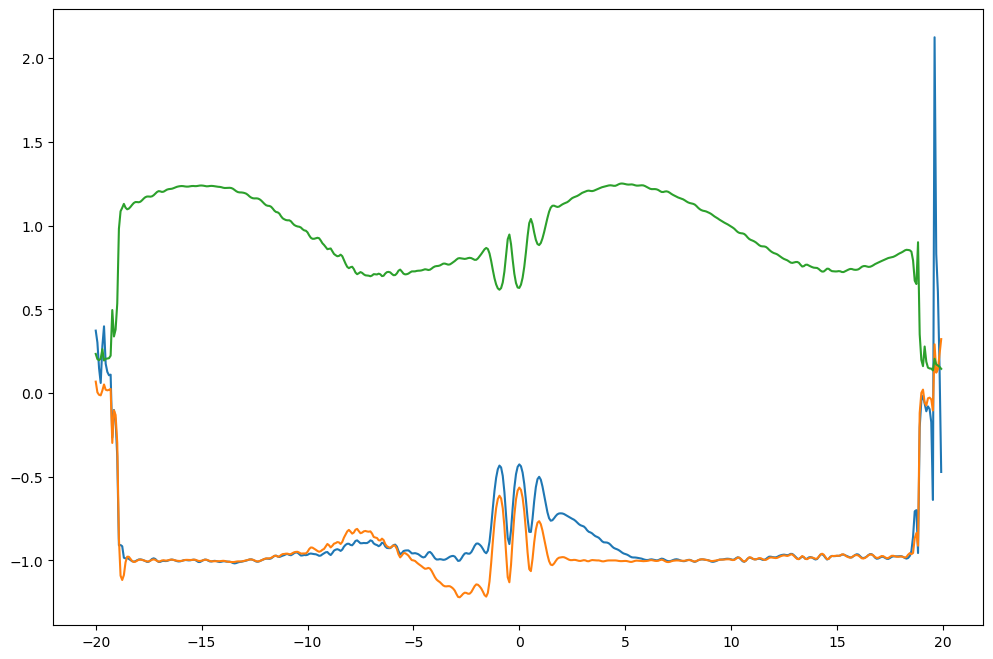

In [22]:
plt.plot(x, f_u_xx)
plt.plot(x, f_u_xxxx)
plt.plot(x, f_uu_x)
plt.show()